# DBSCAN vs DBSCRN

In [53]:
import time
import warnings
import math
from scipy.spatial import distance

from sklearn.datasets import make_blobs
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import cluster
from sklearn import preprocessing

np.random.seed(0)

def cluster_encoder(cluster):
    le = preprocessing.LabelEncoder()
    le.fit(cluster)
    return le.transform(cluster)

## Dataset for testing

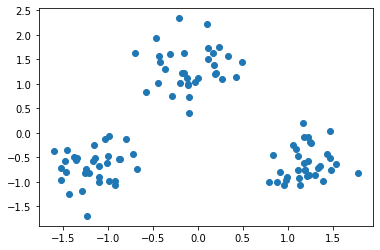

[2 0 1 2 0 0 1 1 1 0 2 0 2 2 1 0 2 2 0 1 1 1 2 1 2 0 1 2 0 0 0 0 2 0 1 0 2
 2 2 1 1 0 2 0 1 0 2 2 1 2 2 1 2 1 0 0 1 1 1 2 1 2 2 0 0 0 0 1 2 1 1 0 1 1
 0 0 0 1 0 2 1 1 2 1 0 2 0 2 2 2 0 0 2 1 1 0 1 2 2 0]


In [54]:
data, y = make_blobs(n_samples=100, centers = [(5, -5), (0, 0), (-5, -5)], cluster_std=1, n_features=2, random_state=5)
data = StandardScaler().fit_transform(data)

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1])
# for i, txt in enumerate(range(len(data))):
#     ax.annotate(i, (data[i,0], data[i,1]), size=15)
plt.show()
print(y)

## Metrics from the lecture

In [55]:
# Purity
def purity(C, G):
    common_items_inclusters = metrics.cluster.contingency_matrix(C, G)
    purity_score = np.sum(np.amax(common_items_inclusters, axis=0)) / np.sum(common_items_inclusters)
    return purity_score

In [56]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances

'''
n_clusters: the number of discovered clusters,
y: real clusters,
c: discovered clusters
'''

'\nn_clusters: the number of discovered clusters,\ny: real clusters,\nc: discovered clusters\n'

## Initial variables

In [57]:
NOT_VISITED = 0
VISTED = 1
CLUSTERED = 2

n = data.shape[0]
cluster = np.array([0] * n)
state = np.array([NOT_VISITED] * n)
cluster_id = 1

## Similarity measure: euclidean distance

In [58]:
def euclidean_distance(a, b):
    distance_measure = 0
    for i in range(len(a)):
         distance_measure += pow((a[i] - b[i]), 2)
    return np.sqrt(distance_measure)

## Similarity measure: cosinus distance

In [59]:
def cosine_similarity(a, b):
    dot = 0
    norm_a = 0
    norm_b = 0
    for i in range(len(a)):
        dot += a[i] * b[i]
        norm_a += a[i]**2
        norm_b += b[i]**2
    return 1 - dot / (norm_a * norm_b)**0.5

## Get reachable neighbors

In [60]:
def get_neighbors(data, current_index, epsilon, distance):
    neighbor_indices = []
    for neighbor_index, neighbor in enumerate(data):
        # print(distance(neighbor, data[current_index]))
        if distance(neighbor, data[current_index]) <= epsilon:
            neighbor_indices.append(neighbor_index)
    return neighbor_indices

## Look for a cluster

In [61]:
def search(current_index, cluster_id, epsilon, minPts, distance):
    neighbor_indices = get_neighbors(data, current_index, epsilon, distance)
    if len(neighbor_indices) >= minPts:
        state[current_index] = CLUSTERED
        cluster[current_index] = cluster_id
        for neighbor_index in neighbor_indices:
            if state[neighbor_index] == NOT_VISITED:
                state[neighbor_index] = CLUSTERED
                cluster[neighbor_index] = cluster_id
                search(neighbor_index, cluster_id, epsilon, minPts, distance)
    else:
        state[current_index] = VISTED

## Clusterization test

### Euclidean distance

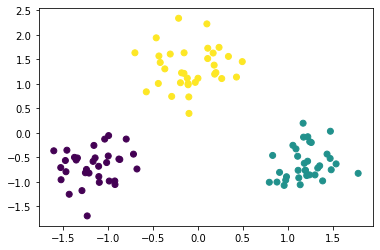

In [66]:
# parameters
epsilon = 0.5
minPts = 3
distance = euclidean_distance

while NOT_VISITED in state:
    not_visited_ids = np.where(state==NOT_VISITED)[0]
    search(not_visited_ids[0], cluster_id, epsilon, minPts, distance)
    cluster_id += 1

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=cluster_encoder(cluster))
plt.show()

# reset to initial state
# cluster = np.array([0] * n)
# state = np.array([NOT_VISITED] * n)

### Evaluation

In [67]:
purity_score_dbscan_eucl = purity(y, cluster_encoder(cluster))
rand_score_dbscan_eucl  = adjusted_rand_score(y, cluster_encoder(cluster))
db_score_dbscan_eucl = davies_bouldin_score(data, cluster_encoder(cluster))
silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(data, cluster_encoder(cluster), metric = 'euclidean')
silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(data, cluster_encoder(cluster), metric = 'cosine')
ARI_dbscan_eucl = metrics.adjusted_rand_score(y, cluster_encoder(cluster))

### Cosine similarity

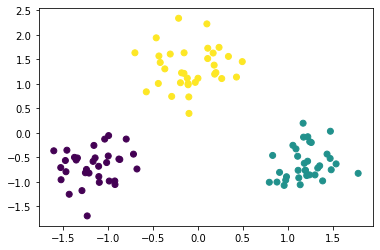

In [69]:
# parameters
epsilon = 0.05
minPts = 10
distance = cosine_similarity

while NOT_VISITED in state:
    not_visited_ids = np.where(state==NOT_VISITED)[0]
    search(not_visited_ids[0], cluster_id, epsilon, minPts, distance)
    cluster_id += 1

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=cluster_encoder(cluster))
plt.show()

# reset to initial state
# cluster = np.array([0] * n)
# state = np.array([NOT_VISITED] * n)

### Evaluation

In [70]:
purity_score_dbscan_cos = purity(y, cluster_encoder(cluster))
rand_score_dbscan_cos = adjusted_rand_score(y, cluster_encoder(cluster))
db_score_dbscan_cos = davies_bouldin_score(data, cluster_encoder(cluster))
silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(data, cluster_encoder(cluster), metric = 'euclidean')
silhouette_score_cos_dbscan_cos = metrics.silhouette_score(data, cluster_encoder(cluster), metric = 'cosine')
ARI_dbscan_cos = metrics.adjusted_rand_score(y, cluster_encoder(cluster))

## All within one function

In [71]:
def dbscan(data, epsilon, minPts, distance):
    
    NOT_VISITED = 0
    VISTED = 1
    CLUSTERED = 2

    n = data.shape[0]
    cluster = np.array([0] * n)
    state = np.array([NOT_VISITED] * n)
    cluster_id = 1
    
    def get_neighbors(data, current_index, epsilon, distance):
        neighbor_indices = []
        for neighbor_index, neighbor in enumerate(data):
            if distance(neighbor, data[current_index]) <= epsilon:
                neighbor_indices.append(neighbor_index)
        return neighbor_indices

    def search(current_index, cluster_id, epsilon, minPts, distance):
        neighbor_indices = get_neighbors(data, current_index, epsilon, distance)
        if len(neighbor_indices) >= minPts:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in neighbor_indices:
                if state[neighbor_index] == NOT_VISITED:
                    state[neighbor_index] = CLUSTERED
                    cluster[neighbor_index] = cluster_id
                    search(neighbor_index, cluster_id, epsilon, minPts, distance)
        else:
            state[current_index] = VISTED

    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0]
        search(not_visited_ids[0], cluster_id, epsilon, minPts, distance)
        cluster_id += 1
    
    return cluster

## DBSCAN wrapped into a class for convenient use

In [72]:
class DBSCAN():

    def __init__(self, epsilon, minPts, distance):
        self.epsilon = epsilon
        self.minPts = minPts
        self.distance = distance

    def fit_transform(self, X):
        result = dbscan(X, self.epsilon, self.minPts, self.distance)
        return result

In [265]:
# c = DBSCAN(0.05, 10, cosine_similarity).fit_transform(data)

# fig, ax = plt.subplots()
# ax.scatter(data[:,0], data[:,1], c=cluster_encoder(c))
# plt.show()

# DBSCRN

## Dataset for testing

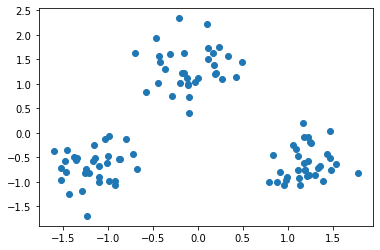

In [110]:
data, y = make_blobs(n_samples=100, centers = [(5, -5), (0, 0), (-5, -5)], cluster_std=1, n_features=2, random_state=5)
data = StandardScaler().fit_transform(data)

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1])
# for i, txt in enumerate(range(len(data))):
#     ax.annotate(i, (data[i,0], data[i,1]), size=15)
plt.show()

## Initial variables

In [111]:
n = data.shape[0] # number of samples

# possible states for each sample 
NOT_VISITED = 0
VISTED = 1
CLUSTERED = 2
state = np.array([NOT_VISITED] * n) # if given point is visited, not visited or clustered

cluster = np.array([0] * n) # clasters ID
cluster_id = 1 # first cluster ID

all_point_indices = list(range(len(data))) # inidces of all points

## KNN

In [112]:
def get_knn(current_index, neighbor_indices, k, distance):
    neighbor_indices.remove(current_index)
    neighbor_distances = []
    for neighbor_index in neighbor_indices:
        distance_measure = distance(data[neighbor_index], data[current_index])
        neighbor_distances.append(distance_measure) 
    sort_indices = np.argsort(neighbor_distances)
    neighbor_indices = np.array(neighbor_indices)
    return neighbor_indices[sort_indices][:k].tolist()

## RNN

In [113]:
def get_pointwise_rnn(point_knn, current_index):
    rnn = []
    for neighbor in point_knn[current_index]:
        if current_index in point_knn[neighbor]:
            rnn.append(neighbor)
    return rnn
    
def get_rnn(point_indices, k):
    point_rnn = {}
    point_knn = {}
    for current_index in point_indices:
        knn = get_knn(current_index, point_indices[:], k, distance)
        point_knn[current_index] = knn
    for current_index in point_indices:
        rnn = get_pointwise_rnn(point_knn, current_index)
        point_rnn[current_index] = rnn
    return point_rnn

## Look for a cluster

In [114]:
def expand_cluster(y, k):
    Sy = [y]
    Stmp = [y]
    while Stmp:
        y_pop = Stmp.pop()
        if len(point_rnn[y_pop]) > 2*k/np.pi:
            Stmp += point_rnn[y_pop]
            Stmp = list(set(Stmp) - set(Sy))
        if not y_pop in Stmp and not y_pop in Sy:
            Sy.append(y_pop)
    return Sy

## Clusterization test

### Euclidean distance

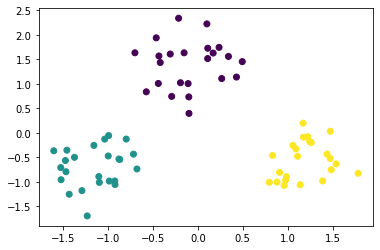

In [115]:
# parameters
k = 15
distance = euclidean_distance

point_rnn = get_rnn(all_point_indices, k)

S_core = []
S_noncore = []

# Look for a cluster within not visited
for point in all_point_indices:
    if len(point_rnn[point]) < k:
        S_noncore.append(point)
    else:
        S_core.append(point)
        clustred_ids = expand_cluster(point, k)
        cluster[clustred_ids] = cluster_id
        cluster_id += 1
        
for point in S_noncore:
    S_core.append(point)
    knn = get_knn(point, S_core, 1, distance)
    cluster[point] = cluster[knn[0]] 
    
fig, ax = plt.subplots()
ax.scatter(data[S_noncore,0], data[S_noncore,1], c=cluster_encoder(cluster[S_noncore]))
plt.show()

# reset to initial state
# cluster = np.array([0] * n)

### Evaluation

In [116]:
purity_score_dbscrn_eucl = purity(y, cluster_encoder(cluster))
rand_score_dbscrn_eucl = adjusted_rand_score(y, cluster_encoder(cluster))
db_score_dbscrn_eucl = davies_bouldin_score(data, cluster_encoder(cluster))
silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(data, cluster_encoder(cluster), metric = 'euclidean')
silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(data, cluster_encoder(cluster), metric = 'cosine')
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, cluster_encoder(cluster))

### Cosine similarity

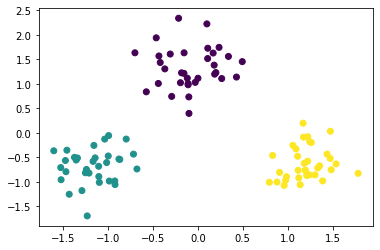

In [117]:
# parameters
k = 15
distance = cosine_similarity

point_rnn = get_rnn(all_point_indices, k)

S_core = []
S_noncore = []

# Look for a cluster within not visited
for point in all_point_indices:
    if len(point_rnn[point]) < k:
        S_noncore.append(point)
    else:
        S_core.append(point)
        clustred_ids = expand_cluster(point, k)
        cluster[clustred_ids] = cluster_id
        cluster_id += 1
        
for point in S_noncore:
    S_core.append(point)
    knn = get_knn(point, S_core, 1, distance)
    cluster[point] = cluster[knn[0]]
    
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=cluster_encoder(cluster[:]))
plt.show()

# reset to initial state
# cluster = np.array([0] * n)

### Evaluation

In [118]:
purity_score_dbscrn_cos = purity(y, cluster_encoder(cluster[:]))
rand_score_dbscrn_cos = adjusted_rand_score(y, cluster_encoder(cluster[:]))
db_score_dbscrn_cos = davies_bouldin_score(data, cluster_encoder(cluster[:]))
silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(data, cluster_encoder(cluster[:]), metric = 'euclidean')
silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(data, cluster_encoder(cluster[:]), metric = 'cosine')
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, cluster_encoder(cluster[:]))

### Result of evaulation according to the metrics from the lecture

In [119]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

,Metrics,DBSACN-euclidean,DBSACN-cosine,DBSCRN-euclidean,DBSCRN-cosine
0,Purity,1.000000,1.000000,1.000000,1.000000
1,Reduce,1.000000,1.000000,1.000000,1.000000
2,Davies-Bouldin,0.355851,0.355851,0.355851,0.355851
3,Silhouette Coefficient-euclidean,0.744669,0.744669,0.744669,0.744669
4,Silhouette Coefficient-cosine,0.954798,0.954798,0.954798,0.954798
5,ARI,1.000000,1.000000,1.000000,1.000000


## All within one function

In [140]:
def dbscrn(data, k, distance):

    def get_knn(current_index, neighbor_indices, k, distance):
        neighbor_indices.remove(current_index)
        neighbor_distances = []
        for neighbor_index in neighbor_indices:
            distance_measure = distance(data[neighbor_index], data[current_index])
            neighbor_distances.append(distance_measure) 
        sort_indices = np.argsort(neighbor_distances)
        neighbor_indices = np.array(neighbor_indices)
        return neighbor_indices[sort_indices][:k].tolist()

    def get_pointwise_rnn(point_knn, current_index):
        rnn = []
        for neighbor in point_knn[current_index]:
            if current_index in point_knn[neighbor]:
                rnn.append(neighbor)
        return rnn

    def get_rnn(point_indices, k):
        point_rnn = {}
        point_knn = {}
        for current_index in point_indices:
            knn = get_knn(current_index, point_indices[:], k, distance)
            point_knn[current_index] = knn
        for current_index in point_indices:
            rnn = get_pointwise_rnn(point_knn, current_index)
            point_rnn[current_index] = rnn
        return point_rnn

    def expand_cluster(y, k):
        Sy = [y]
        Stmp = [y]
        while Stmp:
            y_pop = Stmp.pop()
            if len(point_rnn[y_pop]) > 2*k/np.pi:
                Stmp += point_rnn[y_pop]
                Stmp = list(set(Stmp) - set(Sy))
            if not y_pop in Stmp and not y_pop in Sy:
                Sy.append(y_pop)
        return Sy


    n = data.shape[0] # number of samples

    cluster = np.array([0] * n) # clasters ID
    cluster_id = 1 # first cluster ID
    all_point_indices = list(range(len(data))) # inidces of all points
    point_rnn = get_rnn(all_point_indices, k)

    S_core = []
    S_noncore = []

    # Look for a cluster within not visited
    for point in all_point_indices:
        if len(point_rnn[point]) < k:
            S_noncore.append(point)
        else:
            S_core.append(point)
            clustred_ids = expand_cluster(point, k)
            cluster[clustred_ids] = cluster_id
            cluster_id += 1
            
    for point in S_noncore:
        S_core.append(point)
        knn = get_knn(point, S_core, 1, distance)
        cluster[point] = cluster[knn[0]]
        
    return cluster

## DBSCRN wrapped into a class for convenient use

In [141]:
class DBSCRN():

    def __init__(self, k, distance):
        self.k = k
        self.distance = distance

    def fit_transform(self, X):
        result = dbscrn(X, self.k, self.distance)
        return result

In [266]:
# c = DBSCRN(15, cosine_similarity).fit_transform(data)

# fig, ax = plt.subplots()
# ax.scatter(data[:,0], data[:,1], c=cluster_encoder(c))
# plt.show()

# Algorithms comparison

In [313]:
import time
import warnings
import math
from scipy.spatial import distance

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import cluster

In [120]:
# Data of various shapes
# Inspired by: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
n_samples = 300
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

datasets = [
    noisy_circles,
    noisy_moons,
    varied, 
    aniso,
    blobs,
    no_structure,
]

## Noisy Circles

### DBSCAN Euclidian

CPU times: user 578 ms, sys: 0 ns, total: 578 ms
Wall time: 641 ms


array([1, 2, 3, 1, 2, 2, 3, 3, 3, 2, 1, 2, 1, 1, 3, 2, 1, 1, 2, 3, 3, 3,
       1, 3, 1, 2, 3, 1, 2, 2, 2, 2, 1, 2, 3, 2, 1, 1, 1, 3, 3, 2, 1, 2,
       3, 2, 1, 1, 3, 1, 1, 3, 1, 3, 2, 2, 3, 3, 3, 1, 3, 1, 1, 2, 2, 2,
       2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 1, 3, 3, 1, 3, 2, 1, 2, 1,
       1, 1, 2, 2, 1, 3, 3, 2, 3, 1, 1, 2])

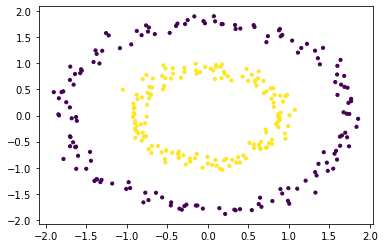

In [296]:
%%time
X, y = noisy_circles
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.5, 25, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));
c

#### Evaluaton

In [299]:
purity_score_dbscan_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_eucl  = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCAN Cosinus

CPU times: user 906 ms, sys: 0 ns, total: 906 ms
Wall time: 1.35 s


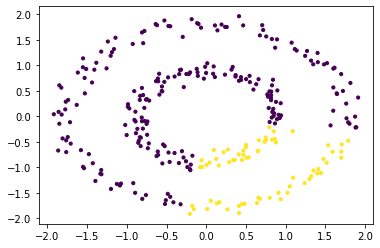

In [26]:
%%time
X, y = noisy_circles
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.003, 0.1, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluaton

In [300]:
purity_score_dbscan_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Euclidian

CPU times: user 1.45 s, sys: 46.9 ms, total: 1.5 s
Wall time: 1.86 s


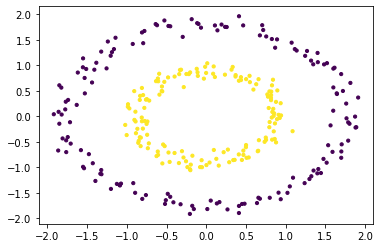

In [27]:
%%time
X, y = noisy_circles
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(15, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [301]:
purity_score_dbscrn_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_eucl = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Cosinus

CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.65 s


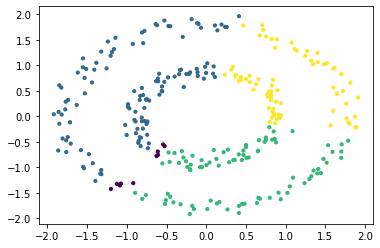

In [28]:
%%time
X, y = noisy_circles
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(8, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [ ]:
purity_score_dbscrn_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### Table

In [ ]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

## Noisy Moons

### DBSCAN Euclidian

CPU times: user 703 ms, sys: 15.6 ms, total: 719 ms
Wall time: 954 ms


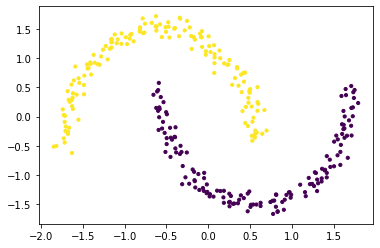

In [364]:
%%time
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.6, 25, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [365]:
purity_score_dbscan_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_eucl  = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(X,cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCAN Cosinus

CPU times: user 703 ms, sys: 0 ns, total: 703 ms
Wall time: 890 ms


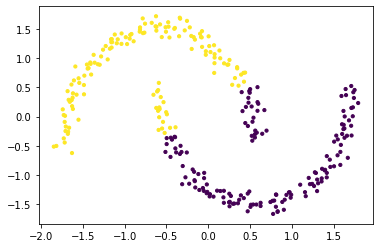

In [366]:
%%time
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.009, 1, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [367]:
purity_score_dbscan_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_cos  = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_cos = davies_bouldin_score(X, y_pred)
silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_cos = metrics.adjusted_rand_score(y, vcluster_encoder(y_pred))

### DBSCRN Euclidian

CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 1.35 s


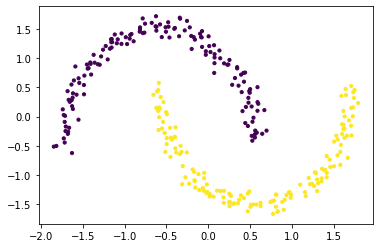

In [368]:
%%time
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(15, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [369]:
purity_score_dbscrn_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_eucl = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_eucl = davies_bouldin_score(X, cluster_encoder(y_pred)
silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Cosinus

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.58 s


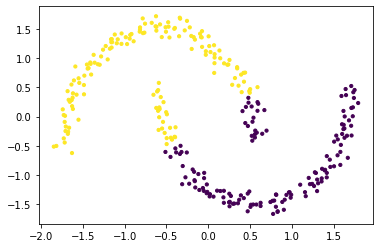

In [370]:
%%time
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(13, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [371]:
purity_score_dbscrn_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### Table - Noisy Moons

In [372]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

,Metrics,DBSACN-euclidean,DBSACN-cosine,DBSCRN-euclidean,DBSCRN-cosine
0,Purity,1.000000,0.850000,0.846667,0.846667
1,Reduce,1.000000,0.488292,0.478970,0.478970
2,Davies-Bouldin,1.017894,0.812746,0.814561,0.814561
3,Silhouette Coefficient-euclidean,0.389014,0.492684,0.491918,0.491918
4,Silhouette Coefficient-cosine,0.477589,0.694727,0.696253,0.696253
5,ARI,1.000000,0.488292,0.478970,0.478970


## Varied

### DBSCAN Euclidian

CPU times: user 750 ms, sys: 0 ns, total: 750 ms
Wall time: 1.1 s


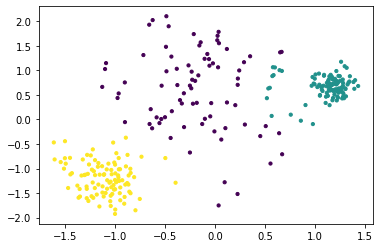

In [33]:
%%time
X, y = varied
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.5, 35, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [359]:
purity_score_dbscan_eucl = purity(y,cluster_encoder(y_pred))
rand_score_dbscan_eucl  = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_eucl = metrics.adjusted_rand_score(y,cluster_encoder(y_pred))

### DBSCAN Cosinus

CPU times: user 1.08 s, sys: 31.2 ms, total: 1.11 s
Wall time: 1.76 s


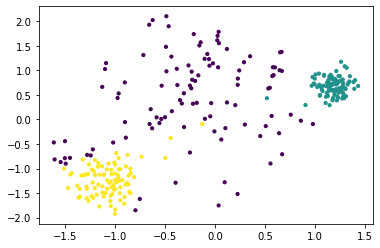

In [34]:
%%time
X, y = varied
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.003, 15, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [360]:
purity_score_dbscan_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_cos  = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Euclidian

CPU times: user 1.05 s, sys: 15.6 ms, total: 1.06 s
Wall time: 1.29 s


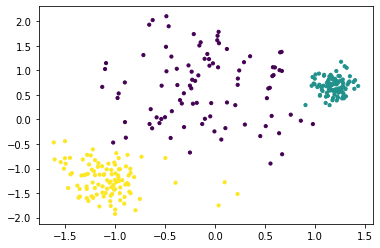

In [35]:
%%time
X, y = varied
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(8, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [361]:
purity_score_dbscrn_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_eucl = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Cosinus

CPU times: user 2.12 s, sys: 46.9 ms, total: 2.17 s
Wall time: 3.82 s


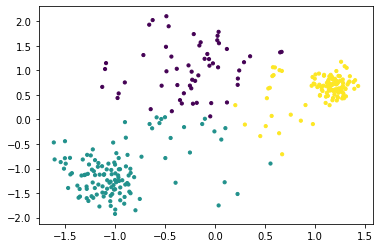

In [36]:
%%time
X, y = varied
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(15, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [ ]:
purity_score_dbscrn_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### Table - Varied

In [362]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

,Metrics,DBSACN-euclidean,DBSACN-cosine,DBSCRN-euclidean,DBSCRN-cosine
0,Purity,0.656667,0.656667,0.656667,0.656667
1,Reduce,0.517337,0.517337,0.517337,0.517337
2,Davies-Bouldin,4.267932,4.267932,4.267932,4.267932
3,Silhouette Coefficient-euclidean,0.424055,0.424055,0.424055,0.424055
4,Silhouette Coefficient-cosine,0.438460,0.438460,0.438460,0.438460
5,ARI,0.517337,0.517337,0.517337,0.517337


## Aniso

### DBSCAN Euclidian

CPU times: user 797 ms, sys: 15.6 ms, total: 812 ms
Wall time: 932 ms


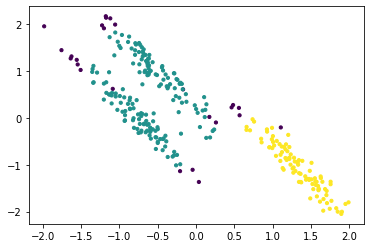

In [353]:
%%time
X, y = aniso
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.5, 35, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [354]:
purity_score_dbscan_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_eucl  = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCAN Cosinus

CPU times: user 1.48 s, sys: 46.9 ms, total: 1.53 s
Wall time: 2.82 s


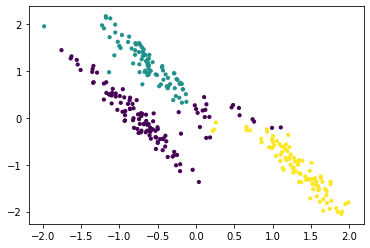

In [38]:
%%time
X, y = aniso
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.02, 35, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [355]:
purity_score_dbscan_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred) , metric= 'cosine')
ARI_dbscan_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Euclidian

CPU times: user 1.03 s, sys: 15.6 ms, total: 1.05 s
Wall time: 1.55 s


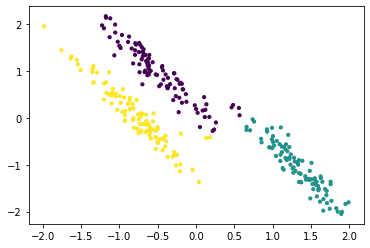

In [40]:
%%time
X, y = aniso
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(9, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [356]:
purity_score_dbscrn_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_eucl = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Cosinus

CPU times: user 1.06 s, sys: 15.6 ms, total: 1.08 s
Wall time: 1.67 s


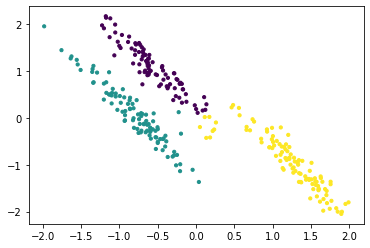

In [41]:
%%time
X, y = aniso
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(15, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [357]:
purity_score_dbscrn_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### Table - Aniso

In [358]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

,Metrics,DBSACN-euclidean,DBSACN-cosine,DBSCRN-euclidean,DBSCRN-cosine
0,Purity,0.656667,0.656667,0.656667,0.656667
1,Reduce,0.517337,0.517337,0.517337,0.517337
2,Davies-Bouldin,4.267932,4.267932,4.267932,4.267932
3,Silhouette Coefficient-euclidean,0.424055,0.424055,0.424055,0.424055
4,Silhouette Coefficient-cosine,0.438460,0.438460,0.438460,0.438460
5,ARI,0.517337,0.517337,0.517337,0.517337


## Blobs

### DBSCAN Euclidian

CPU times: user 547 ms, sys: 0 ns, total: 547 ms
Wall time: 562 ms


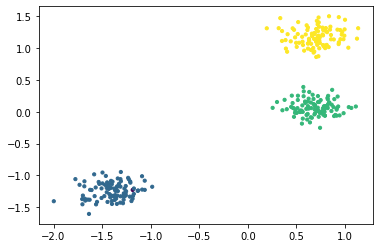

In [121]:
%%time
X, y = blobs
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.5, 90, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [126]:
purity_score_dbscan_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_eucl  = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscan_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCAN Cosinus

CPU times: user 797 ms, sys: 15.6 ms, total: 812 ms
Wall time: 1.14 s


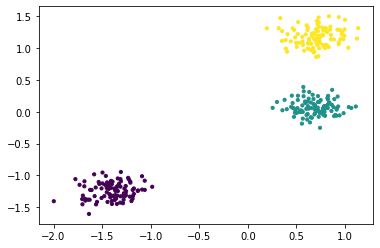

In [315]:
%%time
X, y = blobs
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.004, 3, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [127]:
purity_score_dbscan_cos = purity(y, cluster_encoder(y_pred))
rand_score_dbscan_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscan_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(y_pred) , metric= 'cosine')
ARI_dbscan_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Euclidian

CPU times: user 1.03 s, sys: 15.6 ms, total: 1.05 s
Wall time: 1.25 s


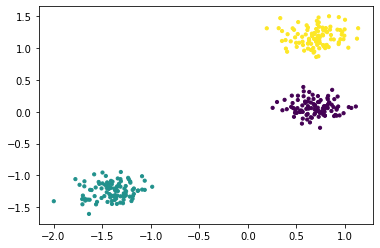

In [317]:
%%time
X, y = blobs
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(9, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [318]:
purity_score_dbscrn_eucl = purity(y, cluster_encoder(y_pred))
rand_score_dbscrn_eucl = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_eucl = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### DBSCRN Cosinus

CPU times: user 953 ms, sys: 15.6 ms, total: 969 ms
Wall time: 1.21 s


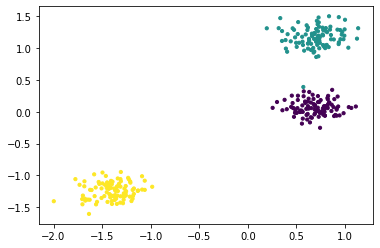

In [319]:
%%time
X, y = blobs
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(15, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [128]:
purity_score_dbscrn_cos = purity(y, y_pred)
rand_score_dbscrn_cos = adjusted_rand_score(y, cluster_encoder(y_pred))
db_score_dbscrn_cos = davies_bouldin_score(X, cluster_encoder(y_pred))
silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'euclidean')
silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(y_pred), metric = 'cosine')
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, cluster_encoder(y_pred))

### Table - Blobs

In [321]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

,Metrics,DBSACN-euclidean,DBSACN-cosine,DBSCRN-euclidean,DBSCRN-cosine
0,Purity,1.000000,1.000000,0.996667,0.996667
1,Reduce,1.000000,1.000000,0.989983,0.989983
2,Davies-Bouldin,0.355851,0.281143,0.284332,0.284332
3,Silhouette Coefficient-euclidean,0.744669,0.800848,0.795853,0.795853
4,Silhouette Coefficient-cosine,0.954798,0.950216,0.951830,0.951830
5,ARI,1.000000,1.000000,0.989983,0.989983


## No Structure

##### DBSCAN Euclidian

CPU times: user 594 ms, sys: 15.6 ms, total: 609 ms
Wall time: 632 ms


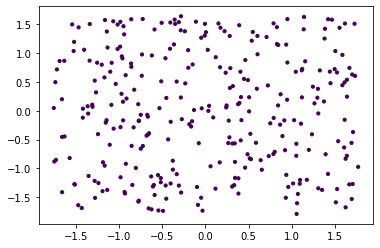

In [163]:
%%time
X, y = no_structure
X = StandardScaler().fit_transform(X)
y = np.zeros(shape=X.shape[0])
algorithm = DBSCAN(0.5, 8, euclidean_distance)
y_pred = algorithm.fit_transform(X)
cluster_encoder(y_pred)
plt.scatter(X[:, 0], X[:, 1], s=10, c=y_pred);

#### Evaluation

In [159]:
purity_score_dbscan_eucl = purity(y, y_pred)
rand_score_dbscan_eucl  = adjusted_rand_score(y, y_pred)
# db_score_dbscan_eucl = davies_bouldin_score(X, y_pred)
db_score_dbscan_eucl = None
# silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(X, y_pred, metric = 'euclidean')
silhouette_score_eucl_dbscan_eucl = None
# silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(X, y_pred, metric = 'cosine')
silhouette_score_cos_dbscan_eucl =None
ARI_dbscan_eucl = metrics.adjusted_rand_score(y, y_pred)

##### DBSCAN Cosinus

CPU times: user 609 ms, sys: 46.9 ms, total: 656 ms
Wall time: 744 ms


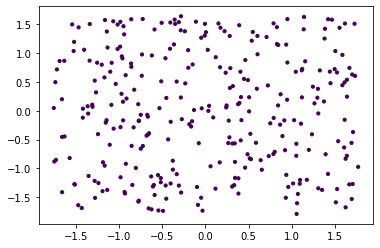

In [89]:
%%time
X, y = no_structure
X = StandardScaler().fit_transform(X)
algorithm = DBSCAN(0.5, 8, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [160]:
purity_score_dbscan_cos = purity(y, y_pred)
rand_score_dbscan_cos = adjusted_rand_score(y, y_pred)
# db_score_dbscan_cos = davies_bouldin_score(X, y_pred)
db_score_dbscan_cos = None
# silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(X, y_pred, metric = 'euclidean')
silhouette_score_eucl_dbscan_cos = None
# silhouette_score_cos_dbscan_cos = metrics.silhouette_score(X, y_pred , metric= 'cosine')
silhouette_score_cos_dbscan_cos = None
ARI_dbscan_cos = metrics.adjusted_rand_score(y, y_pred)

##### DBSCRN Euclidian

CPU times: user 1.44 s, sys: 15.6 ms, total: 1.45 s
Wall time: 1.8 s


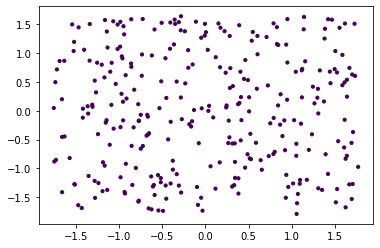

In [91]:
%%time
X, y = no_structure
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(9, euclidean_distance)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [ ]:
purity_score_dbscrn_eucl = purity(y, y_pred)
rand_score_dbscrn_eucl = adjusted_rand_score(y, y_pred)
# db_score_dbscrn_eucl = davies_bouldin_score(X, y_pred)
db_score_dbscrn_eucl = None
# silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(X, y_pred, metric = 'euclidean')
silhouette_score_eucl_dbscrn_eucl = None
# silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(X, y_pred, metric = 'cosine')
silhouette_score_cos_dbscrn_eucl = None
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, y_pred)

##### DBSCRN Cosinus

CPU times: user 1.44 s, sys: 46.9 ms, total: 1.48 s
Wall time: 1.56 s


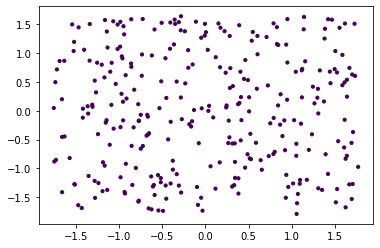

In [97]:
%%time
X, y = no_structure
X = StandardScaler().fit_transform(X)
algorithm = DBSCRN(14, cosine_similarity)
y_pred = algorithm.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10, c=cluster_encoder(y_pred));

#### Evaluation

In [161]:
purity_score_dbscrn_cos = purity(y, y_pred)
rand_score_dbscrn_cos = adjusted_rand_score(y, y_pred)
# db_score_dbscrn_cos = davies_bouldin_score(X, y_pred)
db_score_dbscrn_cos = None
# silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(X, y_pred, metric = 'euclidean')
silhouette_score_eucl_dbscrn_cos = None
# silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(X, y_pred, metric = 'cosine')
silhouette_score_cos_dbscrn_cos = None
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, y_pred)

### Table - No Structure

In [162]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

,Metrics,DBSACN-euclidean,DBSACN-cosine,DBSCRN-euclidean,DBSCRN-cosine
0,Purity,1.0,1.0,1.0,1.0
1,Reduce,1.0,1.0,1.0,1.0
2,Davies-Bouldin,NaN,NaN,NaN,NaN
3,Silhouette Coefficient-euclidean,NaN,NaN,NaN,NaN
4,Silhouette Coefficient-cosine,NaN,NaN,NaN,NaN
5,ARI,1.0,1.0,1.0,1.0


# Evaluation by lecture

### Dataset from lecture

In [132]:
X = np.array(
    [[4.2, 4.0], 
    [5.9, 3.9],
    [2.8, 3.5],
    [12.0, 1.3],
    [10.0, 1.3],
    [1.1, 3.0],
    [0.0, 2.4],
    [2.4, 2.0],
    [11.5, 1.8],
    [11.0, 1.0],
    [0.9, 0.0],
    [1.0, 1.5]], np.single)


# real clusters
y =  np.array([1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1])

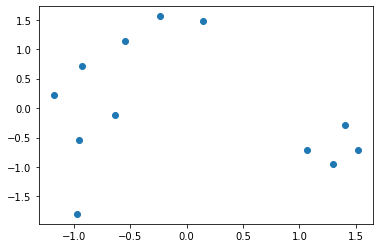

In [133]:
X = StandardScaler().fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
plt.show()

## Evaluations from lecture

### DBSACN

#### Euclidean

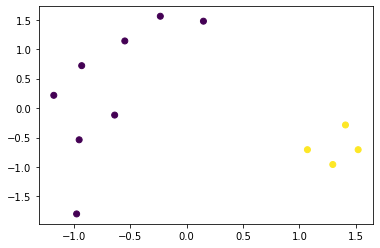

In [134]:
G_dbscan_eucl = DBSCAN(0.5, 3, distance=euclidean_distance).fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=cluster_encoder(G_dbscan_eucl))
plt.show()

In [135]:
purity_score_dbscan_eucl = purity(y, cluster_encoder(G_dbscan_eucl))
rand_score_dbscan_eucl  = adjusted_rand_score(y, cluster_encoder(G_dbscan_eucl))
db_score_dbscan_eucl = davies_bouldin_score(X, cluster_encoder(G_dbscan_eucl))
silhouette_score_eucl_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(G_dbscan_eucl), metric = 'euclidean')
silhouette_score_cos_dbscan_eucl = metrics.silhouette_score(X, cluster_encoder(G_dbscan_eucl), metric = 'cosine')
ARI_dbscan_eucl = metrics.adjusted_rand_score(y, cluster_encoder(G_dbscan_eucl))

#### Cosinus

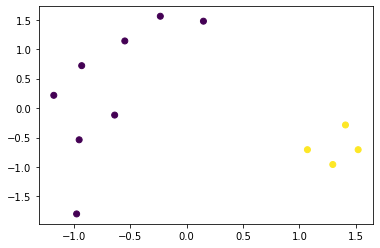

In [136]:
G_dbscan_cos = DBSCAN(0.5, 3, distance=cosine_similarity).fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=cluster_encoder(G_dbscan_cos))
plt.show()

In [137]:
purity_score_dbscan_cos = purity(y, cluster_encoder(G_dbscan_cos))
rand_score_dbscan_cos = adjusted_rand_score(y, cluster_encoder(G_dbscan_cos))
db_score_dbscan_cos = davies_bouldin_score(X, cluster_encoder(G_dbscan_cos))
silhouette_score_eucl_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(G_dbscan_cos), metric = 'euclidean')
silhouette_score_cos_dbscan_cos = metrics.silhouette_score(X, cluster_encoder(G_dbscan_cos), metric = 'cosine')
ARI_dbscan_cos = metrics.adjusted_rand_score(y, G_dbscan_cos)

#### DBSCRN

#### Euclidean

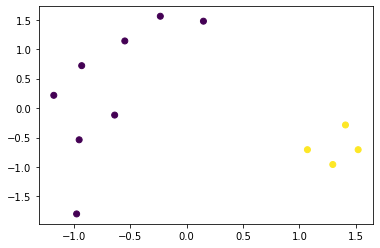

In [142]:
G_dbscrn_eucl = DBSCRN(2, distance=euclidean_distance).fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=cluster_encoder(G_dbscrn_eucl))
plt.show()

In [143]:
purity_score_dbscrn_eucl = purity(y, cluster_encoder(G_dbscrn_eucl))
rand_score_dbscrn_eucl = adjusted_rand_score(y, cluster_encoder(G_dbscrn_eucl))
db_score_dbscrn_eucl = davies_bouldin_score(X, cluster_encoder(G_dbscrn_eucl))
silhouette_score_eucl_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(G_dbscrn_eucl), metric = 'euclidean')
silhouette_score_cos_dbscrn_eucl = metrics.silhouette_score(X, cluster_encoder(G_dbscrn_eucl), metric = 'cosine')
ARI_dbscrn_eucl = metrics.adjusted_rand_score(y, cluster_encoder(G_dbscrn_eucl))

#### Cosinus

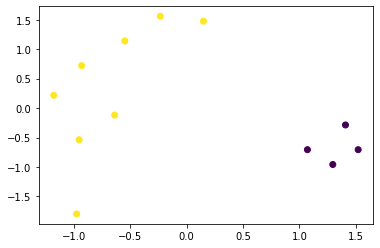

In [144]:
G_dbscrn_cos = DBSCRN(2, distance=cosine_similarity).fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=cluster_encoder(G_dbscrn_cos))
plt.show()

In [145]:
purity_score_dbscrn_cos = purity(y, cluster_encoder(G_dbscrn_cos))
rand_score_dbscrn_cos = adjusted_rand_score(y, cluster_encoder(G_dbscrn_cos))
db_score_dbscrn_cos = davies_bouldin_score(X, cluster_encoder(G_dbscrn_cos))
silhouette_score_eucl_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(G_dbscrn_cos), metric = 'euclidean')
silhouette_score_cos_dbscrn_cos = metrics.silhouette_score(X, cluster_encoder(G_dbscrn_cos), metric = 'cosine')
ARI_dbscrn_cos = metrics.adjusted_rand_score(y, cluster_encoder(G_dbscrn_cos))

## Table

In [146]:
evaluation = {
    "Metrics": ['Purity', 'Reduce', 'Davies-Bouldin', 'Silhouette Coefficient-euclidean', 'Silhouette Coefficient-cosine', 'ARI'], 
    "DBSACN-euclidean": [purity_score_dbscan_eucl, rand_score_dbscan_eucl, db_score_dbscan_eucl, silhouette_score_eucl_dbscan_eucl, silhouette_score_cos_dbscan_eucl, ARI_dbscan_eucl], 
    "DBSACN-cosine": [purity_score_dbscan_cos, rand_score_dbscan_cos, db_score_dbscan_cos, silhouette_score_eucl_dbscan_cos, silhouette_score_cos_dbscan_cos, ARI_dbscan_cos], 
    "DBSCRN-euclidean": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos], 
    "DBSCRN-cosine": [purity_score_dbscrn_cos, rand_score_dbscrn_cos, db_score_dbscrn_cos, silhouette_score_eucl_dbscrn_cos, silhouette_score_cos_dbscrn_cos, ARI_dbscrn_cos]
}
evaluationdf = pd.DataFrame(data=evaluation)

display(evaluationdf)

,Metrics,DBSACN-euclidean,DBSACN-cosine,DBSCRN-euclidean,DBSCRN-cosine
0,Purity,0.916667,0.916667,0.916667,0.916667
1,Reduce,0.789041,0.789041,0.789041,0.789041
2,Davies-Bouldin,0.580299,0.580299,0.580299,0.580299
3,Silhouette Coefficient-euclidean,0.533963,0.533963,0.533963,0.533963
4,Silhouette Coefficient-cosine,0.678404,0.678404,0.678404,0.678404
5,ARI,0.789041,0.789041,0.789041,0.789041
